In [103]:
from fktools import *
import tensorflow as tf
import sklearn
from dist_metric import DistributionOverlapSingle, DistributionOverlap
from time import time

In [104]:
WALK_DIM = 16
LATENT_DIM = 2

X_FILE = "dataset_autoenc_4_X.npz"
Y_FILE = "dataset_autoenc_4_y.npz"

print(int(time()))

1769105154


In [105]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(WALK_DIM,)),
            tf.keras.layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(WALK_DIM, activation='softmax'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


latent_dim = LATENT_DIM
autoencoder = Autoencoder(latent_dim)

In [106]:
X = np.load(X_FILE, allow_pickle=True)['arr_0']
y = np.load(Y_FILE, allow_pickle=True)['arr_0']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

print(f"X train size: {X_train.shape}")
print(f"X test size: {X_test.shape}")

X shape: (12508, 16)
y shape: (12508, 3)
X train size: (10006, 16)
X test size: (2502, 16)


In [107]:
autoencoder.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.KLDivergence(),
    metrics=[DistributionOverlap()]
)

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dist_overlap: 0.4363 - loss: 0.9904
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - dist_overlap: 0.5286 - loss: 0.7286  
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - dist_overlap: 0.5780 - loss: 0.5915
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - dist_overlap: 0.6026 - loss: 0.5245
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - dist_overlap: 0.6175 - loss: 0.4844
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - dist_overlap: 0.6277 - loss: 0.4572
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - dist_overlap: 0.6353 - loss: 0.4372
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - dist_overlap: 0.6411 - loss: 0.4220
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - dist_overlap: 0.6457 - loss: 0.4101
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - dist_overlap: 0.6492 - loss: 0.4007
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - dist_overlap: 0.6521 - l

In [108]:
loss = history.history['loss']
dist_overlap = history.history['dist_overlap']

epochs = range(1, len(loss) + 1)

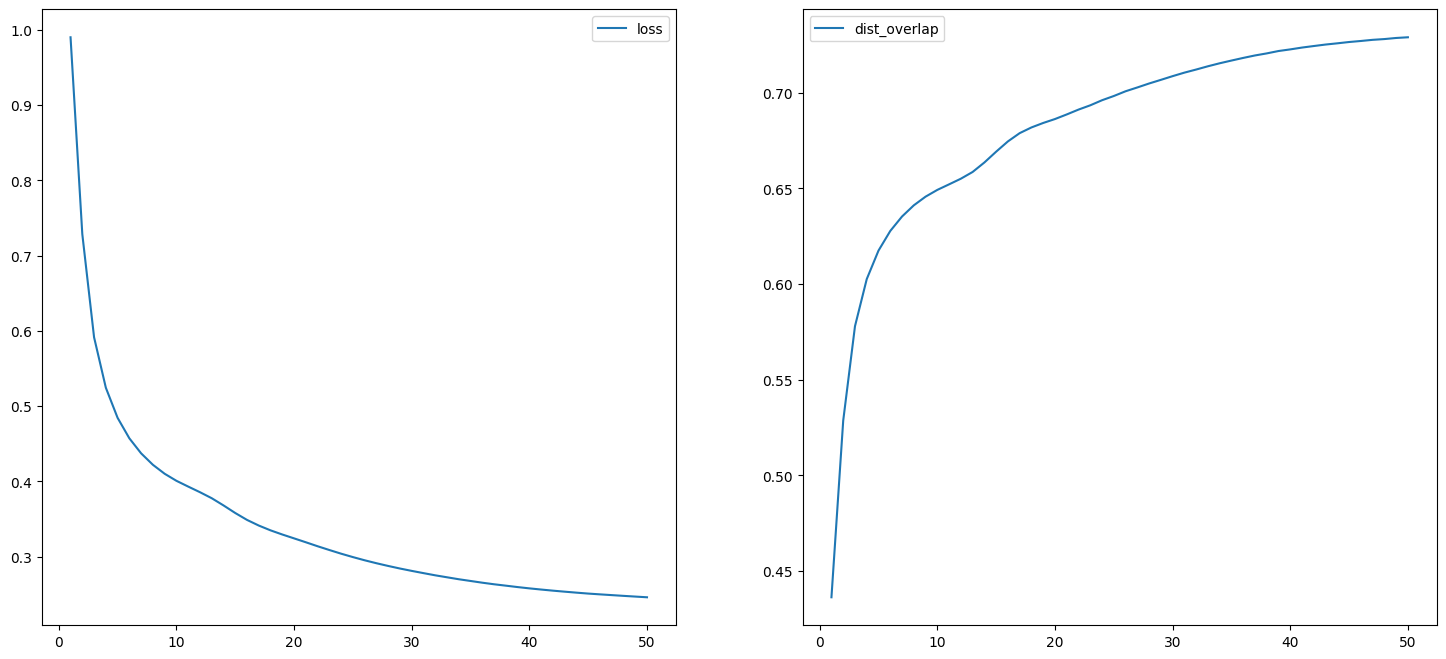

In [109]:
fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0].plot(epochs, loss, label="loss")
ax[0].legend()

ax[1].plot(epochs, dist_overlap, label="dist_overlap")
ax[1].legend()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<BarContainer object of 16 artists>

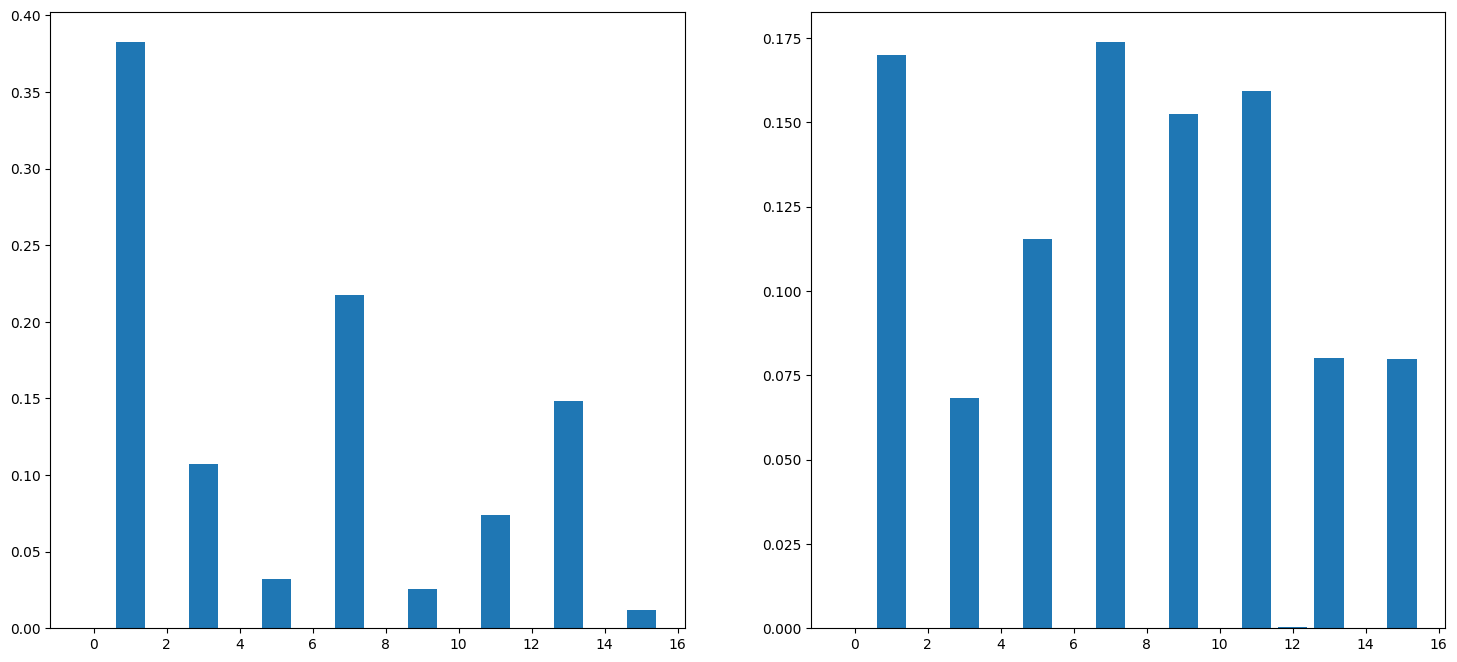

In [110]:
i = 1

pred = autoencoder.predict(X_test)

fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0].bar(np.arange(WALK_DIM), X_test[i])
ax[1].bar(np.arange(WALK_DIM), pred[i])

[[3.6316757  3.6078186 ]
 [0.03019094 0.12456858]
 [0.2778126  0.44852042]
 ...
 [3.3361216  3.57618   ]
 [0.12313247 0.110883  ]
 [4.292333   4.2800064 ]]


Text(0.5, 1.0, 'autoencoder 16-2-16, encoded points')

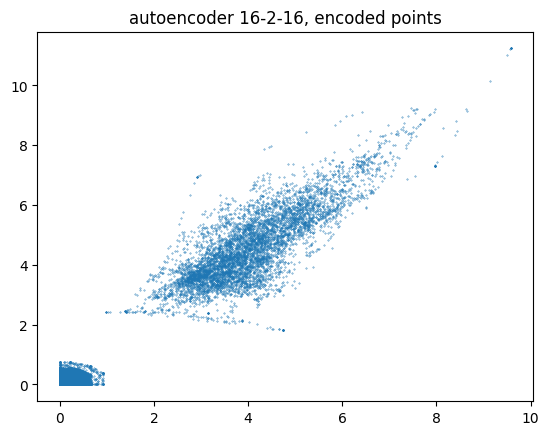

In [111]:
encoded_points = np.array(autoencoder.encoder(X))

print(encoded_points)

np.savez_compressed(f"autoencoder_{WALK_DIM}-{LATENT_DIM}-{WALK_DIM}_encodedpoints_{int(time())}", encoded_points)

plt.scatter(encoded_points[:,0], encoded_points[:,1],s=0.1)
plt.title(f"autoencoder {WALK_DIM}-{LATENT_DIM}-{WALK_DIM}, encoded points")

In [112]:
print(tf.keras.losses.KLD(X_test, pred))
print(np.mean(tf.keras.losses.KLD(X_test, pred)))

tf.Tensor([0.42804044 0.33404863 0.13328272 ... 0.13462755 0.13334976 0.18813102], shape=(2502,), dtype=float32)
0.24759895


In [113]:
encoded_with_params = np.array(autoencoder.encoder(X))



encoded_with_params[:,0] /= np.max(encoded_with_params[:,0])
encoded_with_params[:,1] /= np.max(encoded_with_params[:,1])

Text(0.5, 1.0, 'color is number of steps')

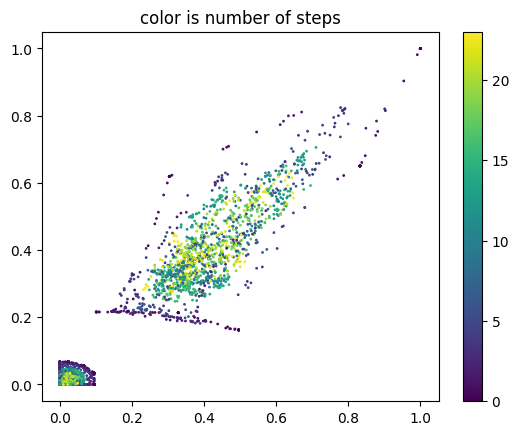

In [114]:
plt.scatter(encoded_with_params[y[:,0]<24,0], encoded_with_params[y[:,0]<24,1], s=1, c=y[y[:,0]<24,0])
plt.colorbar()
plt.title("color is number of steps")

Text(0.5, 1.0, 'color is number of steps')

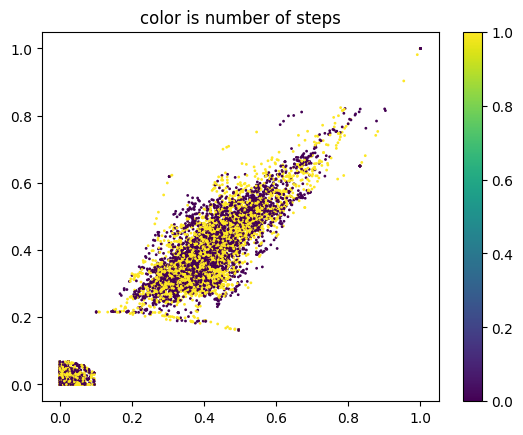

In [115]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=y[:,0]%2)
plt.colorbar()
plt.title("color is number of steps")

Text(0.5, 1.0, 'color is start position')

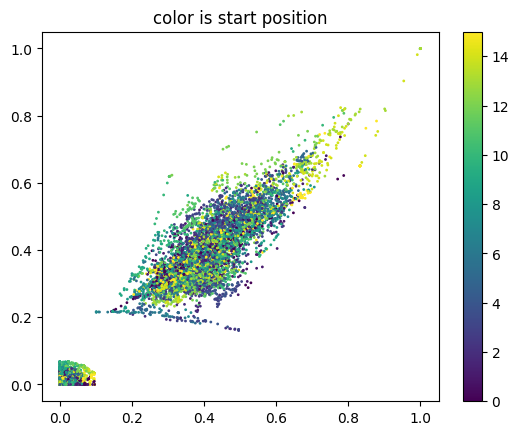

In [116]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=y[:,1])
plt.colorbar()
plt.title("color is start position")

Text(0.5, 1.0, 'color is coin phase')

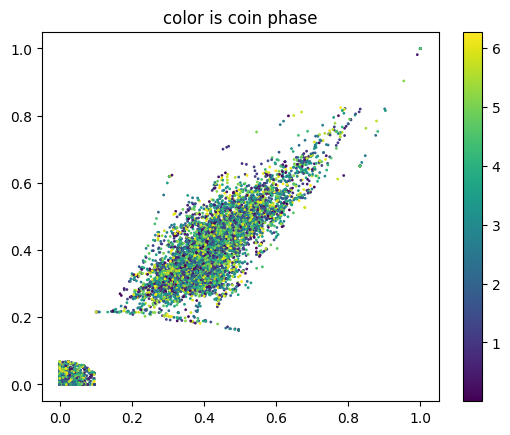

In [117]:
plt.scatter(encoded_with_params[:,0], encoded_with_params[:,1], s=1, c=y[:,2])
plt.colorbar()
plt.title("color is coin phase")

In [118]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(encoded_with_params)
print(pca.explained_variance_ratio_)



[0.9851079  0.01489211]
